# **RETAIN heart failure detection**

An implementation of [RETAIN: An Interpretable Predictive Model for Healthcare using Reverse Time Attention Mechanism](https://arxiv.org/abs/1608.05745) by Choi et al. to predict heart failure based on clinical records.

I was playing around with one of my homeworks, you can watch the [lecture video directly from Coursera](https://www.coursera.org/lecture/advanced-deep-learning-methods-healthcare/applied-attention-models-retain-Ad5QN) to get a better understanding.

### 1. Load libraries

In [350]:
import numpy as np
import pandas as pd
import pickle as pickle

import torch
import torch.nn as nn
from matplotlib import pyplot as plt

# **Prepare dataset:**

### 2. Load dataset
**Dataset consists of several files:**
* **pids:** patient ID
* **vids:** visit ID per patient
* **hfs:** heart failures
* **seqs:** sequences of ICD-9 clinical records per visit per patient
* **types:** mapping of ICD-9 code to ID
* **rtypes:** index mapping of ICD-9 ID, used to simplify code

In [351]:
pids = pd.read_pickle('dataset/pids.pkl')
vids = pd.read_pickle('dataset/vids.pkl')
hfs = pd.read_pickle('dataset/hfs.pkl')
seqs = pd.read_pickle('dataset/seqs.pkl')
types = pd.read_pickle('dataset/types.pkl')
rtypes = pd.read_pickle('dataset/rtypes.pkl')

### 3. Data preview
**Print some dataset stats:**

In [352]:
total_patients = len(pids)
total_visits = len(pd.DataFrame(vids).stack())
total_records = len(pd.DataFrame(seqs).stack().explode())
total_hfs = sum(hfs)
hfs_ratio = sum(hfs) / len(hfs)

highest_visit_count = pd.DataFrame(vids).stack()
highest_visit_count = highest_visit_count .groupby(level=0).count().max()

print(f"Total patients: {total_patients}")
print(f"Total amount of visits: {total_visits}")
print(f"Highest visit amount for a single patient: {highest_visit_count}")
print(f"Total amount of clinical records: {total_records}")
print(f"Total amount of patients with heart failure: {total_hfs}")
print(f"Rato of heart failure patients: {hfs_ratio}")

Total patients: 1000
Total amount of visits: 2375
Highest visit amount for a single patient: 30
Total amount of clinical records: 27115
Total amount of patients with heart failure: 548
Rato of heart failure patients: 0.548


**Get a single patient's data:**

Patients have their ID, amount of visits and information if heart failure occured (that's what we want to predict).

In [353]:
def get_patient_data(index):
    patient_stats = pd.DataFrame({
        "ID": pids[index],
        "Visits": len(vids[index]),
        "Heart failure": bool(hfs[index])
    }, index=[index])

    return patient_stats

In [354]:
print("\nExample patient:")
get_patient_data(3)


Example patient:


,ID,Visits,Heart failure
3,47537,2,False


**Get data of a patient's visit**

Each visit contains listed events according to their ID and ICD-9 code. Function `get_patient_visit` requires patient index (not ID) and visit id.

In [355]:
def get_patient_visit(index, visit):

    patient_visit = pd.DataFrame({
        'event_id': seqs[index][visit]
    })

    patient_visit['event'] = patient_visit.event_id.map(rtypes)

    return patient_visit

In [356]:
print("Details of patient visit:")
get_patient_visit(3, 0)

Details of patient visit:


,event_id,event
0,12,DIAG_041
1,103,DIAG_276
2,262,DIAG_518
3,285,DIAG_560
4,290,DIAG_567
5,292,DIAG_569
6,359,DIAG_707
7,416,DIAG_785
8,39,DIAG_155
9,225,DIAG_456


### 4. Padding and masking:

- **Padding:** inserts 0 to each visit to fill the gap between this visit and visit with highest length. We do that to have same dimensions across all sequences.
- **Masking:** creates a boolean mask to indicate which element was added.
- **Reversing:** according to paper we have to reverse the data to achieve **"reverse time attention mechanism"**. We do reversing only on actual data not the padding.

In [357]:
def collate_fn(data):

    sequences, labels = zip(*data)

    num_patients = len(sequences)
    max_num_visits = 0
    max_num_codes = 0

    for patient in sequences:
        max_num_visits = max(max_num_visits, len(patient))
        for visit in patient:
            max_num_codes = max(max_num_codes, len(visit))

    shape = (num_patients, max_num_visits, max_num_codes)

    y = torch.tensor(labels, dtype=torch.float)
    x = torch.zeros(shape, dtype=torch.long)
    rev_x = torch.zeros(shape, dtype=torch.long)
    masks = torch.zeros(shape, dtype=torch.bool)
    rev_masks = torch.zeros(shape, dtype=torch.bool)

    for i, patient in enumerate(sequences):
        for j, visit in enumerate(patient):

            x[i,j,:len(visit)] = torch.tensor(visit, dtype=torch.long)
            masks[i,j, :len(visit)] = 1

            rev_x[i, len(patient) - j - 1, :len(visit)] = torch.tensor(visit, dtype=torch.long)
            rev_masks[i, len(patient) - j - 1, :len(visit)] = 1
            
    
    return x, masks, rev_x, rev_masks, y

**Loader for train and validation:**

In [358]:
def load_data(train_dataset, val_dataset, collate_fn):

    batch_size = 32

    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=collate_fn
    )
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=collate_fn
    )
    
    return train_loader, val_loader

**Create a class for custom dataset:**

In [359]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, seqs, hfs):
        self.x = seqs
        self.y = hfs
    

    def __len__(self):
        return len(self.x)
    

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

In [360]:
dataset = CustomDataset(seqs, hfs)

split = int(len(dataset)*0.8)
lengths = [split, len(dataset) - split]

train_dataset, val_dataset = torch.utils.data.dataset.random_split(dataset, lengths)

train_loader, val_loader = load_data(train_dataset, val_dataset, collate_fn)

# **RETAIN model**

### 5. Custom layers
- **Alpha attention:** What are the important visits. Alpha attention is a scalar for the i-th visit, tells you the importance of the i-th visit.
- **Beta attention:** Which are the important features within a visit. Beta attention is a vector.
- Attention sum
- Sum embeddings with applied mask

In [361]:
class AlphaAttention(torch.nn.Module):

    def __init__(self, hidden_dim):
        super().__init__()
        self.a_att = nn.Linear(hidden_dim, 1)


    def forward(self, g):
        alpha = self.a_att(g)
        alpha = torch.softmax(alpha, 1)
        return alpha


class BetaAttention(torch.nn.Module):

    def __init__(self, hidden_dim):
        super().__init__()
        self.b_att = nn.Linear(hidden_dim, hidden_dim)


    def forward(self, h):
        beta = self.b_att(h)
        beta = torch.tanh(beta)
        return beta


def attention_sum(alpha, beta, rev_v, rev_masks):
    c = (torch.sum(rev_masks, -1) > 0).type(torch.float)
    c = c.unsqueeze(-1)
    c = torch.sum(alpha * beta * rev_v * c, dim=1)
    return c


def sum_embeddings_with_mask(x, masks):
    x = x * masks.unsqueeze(-1)
    x = torch.sum(x, dim = -2)
    return x

### 6. RETAIN model architecture

In [362]:
class RETAIN(nn.Module):
    
    def __init__(self, num_codes, embedding_dim=128):
        super().__init__()

        self.embedding = nn.Embedding(num_codes, embedding_dim)

        self.rnn_a = nn.GRU(embedding_dim, embedding_dim, batch_first=True)
        self.rnn_b = nn.GRU(embedding_dim, embedding_dim, batch_first=True)

        self.att_a = AlphaAttention(embedding_dim)
        self.att_b = BetaAttention(embedding_dim)

        self.fc = nn.Linear(embedding_dim, 1)

        self.sigmoid = nn.Sigmoid()


    def forward(self, x, masks, rev_x, rev_masks):

        rev_x = self.embedding(rev_x)
        rev_x = sum_embeddings_with_mask(rev_x, rev_masks)

        g, _ = self.rnn_a(rev_x)
        h, _ = self.rnn_b(rev_x)

        alpha = self.att_a(g)
        beta = self.att_b(h)

        c = attention_sum(alpha, beta, rev_x, rev_masks)

        logits = self.fc(c)
        probs = self.sigmoid(logits)
        return probs.squeeze()
    


### 7. Evaluation function

In [363]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score


def eval(model, val_loader):

    
    y_pred = torch.LongTensor()
    y_score = torch.Tensor()
    y_true = torch.LongTensor()

    model.eval()

    for x, masks, rev_x, rev_masks, y in val_loader:
        y_logit = model(x, masks, rev_x, rev_masks)

        y_hat = y_logit >= 0.5

        y_score = torch.cat((y_score,  y_logit.detach().to('cpu')), dim=0)
        y_pred = torch.cat((y_pred,  y_hat.detach().to('cpu')), dim=0)
        y_true = torch.cat((y_true, y.detach().to('cpu')), dim=0)
    
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    roc_auc = roc_auc_score(y_true, y_score)
    
    return p, r, f, roc_auc



### 8. Train the model

In [387]:
retain = RETAIN(num_codes = len(types))
print(retain)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(retain.parameters(), lr=1e-3)
n_epochs = 20

history = []



def train(model, train_loader, val_loader, n_epochs):

    model.train()
    
    for epoch in range(n_epochs):

        train_loss = 0

        for x, masks, rev_x, rev_masks, y in train_loader:
            optimizer.zero_grad()
            y_hat = model(x, masks, rev_x, rev_masks)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()


        
        train_loss = train_loss / len(train_loader)
        p, r, f, roc_auc = eval(model, val_loader)
        history.append([p,r,f,roc_auc])
        print('Epoch: {} \t Training Loss:  {:.6f}, Validation precision: {:.2f}, recall:{:.2f}, f-score: {:.2f}, roc_auc: {:.2f}'.format(epoch, train_loss, p, r, f, roc_auc))

    return round(roc_auc, 2)


train(retain, train_loader, val_loader, n_epochs)

RETAIN(
  (embedding): Embedding(619, 128)
  (rnn_a): GRU(128, 128, batch_first=True)
  (rnn_b): GRU(128, 128, batch_first=True)
  (att_a): AlphaAttention(
    (a_att): Linear(in_features=128, out_features=1, bias=True)
  )
  (att_b): BetaAttention(
    (b_att): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0 	 Training Loss:  0.638744, Validation precision: 0.72, recall:0.69, f-score: 0.70, roc_auc: 0.72
Epoch: 1 	 Training Loss:  0.427312, Validation precision: 0.75, recall:0.78, f-score: 0.76, roc_auc: 0.76
Epoch: 2 	 Training Loss:  0.251399, Validation precision: 0.76, recall:0.77, f-score: 0.76, roc_auc: 0.76
Epoch: 3 	 Training Loss:  0.128183, Validation precision: 0.75, recall:0.78, f-score: 0.77, roc_auc: 0.76
Epoch: 4 	 Training Loss:  0.059215, Validation precision: 0.75, recall:0.78, f-score: 0.76, roc_auc: 0.77
Epoch: 5 	 Training Loss:  0.029711, Validation precision: 0.

0.77

### 9. Evaluate

*Recall = True Positives / (True Positives + False Negatives)*

Higher the recall the higher the ability of network to correctly identify true positives. In case of heart failure it's important. Incorrectly predicting false positives is safe because additional diagnosis for such patient won't cause harm.

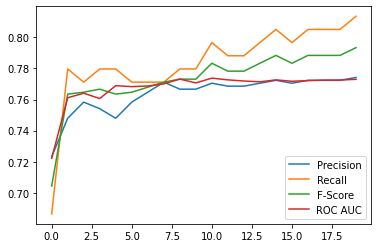

In [390]:
plt.plot(history)
plt.legend(['Precision', 'Recall', 'F-Score', 'ROC AUC'])
plt.show()

In [391]:
print("Precision = {} Recall = {} f-score = {}  roc_auc = {}".format(*eval(retain, val_loader)))


for x, masks, rev_x, rev_masks, y in val_loader:
    y_hat = retain(x, masks, rev_x, rev_masks)
    
    y_hat_single = y_hat[0]
    pred = y_hat_single > 0.5

    print(f"prediction = {pred}\t y = {bool(y[0])}\t which is {'correct' if pred == y[0] else 'incorrect'}\t y_hat = {y_hat_single}")


Precision = 0.7741935483870968 Recall = 0.8135593220338984 f-score = 0.7933884297520662  roc_auc = 0.7728916907813146
prediction = True	 y = False	 which is incorrect	 y_hat = 0.9988961219787598
prediction = True	 y = True	 which is correct	 y_hat = 0.9999998807907104
prediction = True	 y = True	 which is correct	 y_hat = 0.9837378263473511
prediction = True	 y = True	 which is correct	 y_hat = 0.9956557750701904
prediction = True	 y = True	 which is correct	 y_hat = 0.981170654296875
prediction = False	 y = False	 which is correct	 y_hat = 0.011174116283655167
prediction = True	 y = True	 which is correct	 y_hat = 0.7616040110588074


### 10. Save the model

In [389]:
torch.save(retain.state_dict(), "model.pt")